### Sensitivity of hydraulic head at a point to Robin boundary head value under steady state flow conditions

The sensitivity of hydraulic head ($h$) at a given point ($x'$) to the hydraulic head value specified on a Robin boundary (i.e. on $\Gamma_3$) under steady state flow conditions in a one-dimensional plane can be calculated using an adjoint state-based approach as:
$$\begin{align}\cr
\frac{\partial h(x')}{\partial h_{\Gamma_3}}=-\bf{\Psi}^{*\,T}\frac{\partial A}{\partial \it{h_{\Gamma_3}}}\bf{h}
\cr\cr\end{align}$$
This expression states that this sensitivity is equal to the dot product of the adjoint state vector $\bf{\Psi}^{*}$, the derivative of the matrix $\bf{A}$ with respect to $h_{\Gamma_3}$, and the hydraulic head vector $\bf{h}$. All elements of the vector $\bf{\partial q}$/$\partial \it{h_{\Gamma_3}}$ are equal to one, with the except of the cell containing the Dirichlet boundary condition. In this way, the vector $\bf{\partial q}$/$\partial \it{h_{\Gamma_3}}$ acts as a filter on the values contained in the vectors $\bf{\Psi^*}$ and $\bf{h}$.

This discrete solution is equivalent to the integral of the product of the Robin boundary conductance term with the adjoint state variable along the Robin boundary, as calculated via the continuous derivation approach.

### 1. Model setup

Here we define the model as a callable function, since it will be used by each of:
1. The forward model, featuring a 'base' set of parameter values;
2. A perturbed version of the forward model, featuring an infinitesimal increase in $h_{\Gamma_3}$; and
3. The adjoint state model.

Each model is defined using the following six parameters:
1. Number of model columns ($ncol$)
2. Cell width along rows ($delr$)
3. Hydraulic conductivity ($K$)
4. Hydraulic head specified on Dirichlet boundary ($h_{\Gamma_1}$) 
5. Hydraulic head specified on Robin boundary ($h_{\Gamma_3}$) 
6. Conductance specified on Robin boundary ($c_{\Gamma_3}$) 

The variable $md$ is used to specify the working directory for each model.

Top and bottom of aquifer elevations are set to -100.0 and -101.0 metres respectively (resulting in an aquifer that is one metre thick) to ensure confined conditions.

Robin boundary conditions are specified on the left-hand side of the model to represent inflows.

Dirichlet boundary conditions are specified on the right-hand side of the model to represent outflows.

Relatively tight convergence criteria values (i.e. 10$^{-6}$) are specified to ensure accuracy of perturbation-based sensitivities, which are based on differences between forward model outputs.

The hydraulic head observation of interest is located at the midpoint of the model domain.

In [1]:
%matplotlib inline
import flopy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import flopy.utils.binaryfile as bf

def model(md, nrow, ncol, delr, K, BC1h, BC3h, BC3c):
    ml =  flopy.modflow.Modflow(modelname='model', model_ws=md)
    nrow = 1
    flopy.modflow.ModflowDis(ml, nlay=1, nrow=1, ncol=ncol, nper=1, delr=delr, delc=1., 
                             top=-100.0, botm=-101.0, steady=True, perlen=1., nstp=1)
    ibound = np.ones([nrow, ncol], dtype=int)
    ibound[:, ncol-1] = -1 
    strt = BC1h*np.ones([nrow, ncol], dtype=float)
    flopy.modflow.ModflowBas(ml, ibound=ibound, strt=strt)
    flopy.modflow.ModflowLpf(ml, hk=K, vka=-999., ss=-999., sy=-999., ipakcb=53)
    flopy.modflow.ModflowGhb(ml, stress_period_data={0: [0, 0, 0, BC3h, BC3c]}, ipakcb=53)
    flopy.modflow.ModflowPcg(ml, hclose=1e-6, rclose=1e-6)
    flopy.modflow.ModflowOc(ml, stress_period_data={(0,0): ['save head', 'save budget']})
    return ml

flopy is installed in C:\Python27\Lib\site-packages\flopy


Values for the 'base' parameter set are defined as follows. These can be modified to demonstrate the method for other model configurations.

In [2]:
nrow = 1
ncol = 7
ocol = (ncol-1)/2
delr = 1.0
K    = 0.2
BC1h = 1.0
BC3h = 40.0
BC3c = 1.0
dpar = 1e-4

The model grid and boundary conditions can be presented visually as follows.

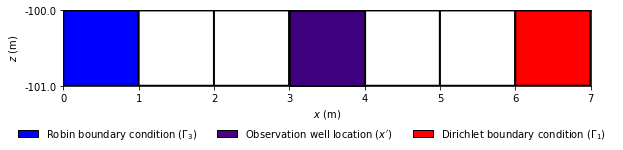

In [3]:
f,s = plt.subplots(1, 1, figsize=[24.00/2.54, 7.00/2.54])
s.set_aspect('equal')
grid = np.hstack([np.zeros([1,1]), 0.5*np.ones([1, ncol-2]), np.ones([1,1])])
s.pcolor(grid, edgecolors='k', linewidths=2, cmap='bwr', vmin=0.0, vmax=1.0)
grid[0, ocol] = 2.
s.pcolor(np.ma.masked_not_equal(grid, 2.), edgecolors='k', linewidths=2, cmap='Purples', vmin=0.0, vmax=2.0)
s.set_xlabel('$x$ (m)')
s.set_ylabel('$z$ (m)')
s.set_yticks([0., 1.])
s.set_yticklabels([-101., -100.])
l = f.legend(handles=[Patch(facecolor='b', edgecolor='k', label='Robin boundary condition ($\Gamma_3$)'),
                      Patch(facecolor='indigo', edgecolor='k', label="Observation well location ($x'$)"),
                      Patch(facecolor='r', edgecolor='k', label='Dirichlet boundary condition ($\Gamma_1$)')], 
             fancybox=False, frameon=False, loc=8, ncol=3)

### 2. Sensitivity calculation using perturbation-based approach

First, the forward model featuring the 'base' parameter set is run.

In [4]:
md = 'forward_base'
ml = model(md, nrow, ncol, delr, K, BC1h, BC3h, BC3c)    

ml.write_input()
success, buff = ml.run_model(silent=True)

hds_base = np.reshape(np.loadtxt(md+'/'+'HDS.arr'), [1, ncol])
hob_base = float(hds_base[0, ocol])

The spatial distribution of hydraulic head calculated by the 'base' forward model can be presented visually as follows.

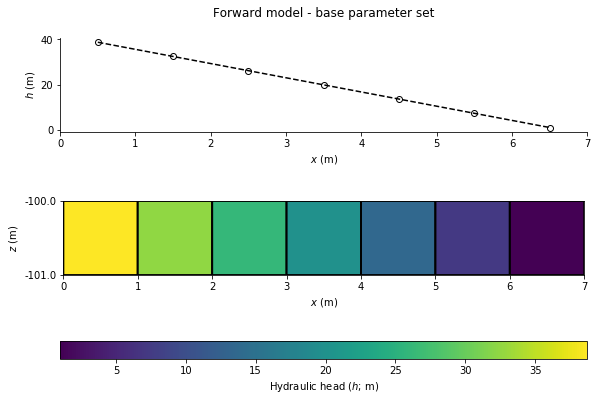

In [5]:
f,s = plt.subplots(2, 1, figsize=[24.00/2.54, 17.00/2.54])
s[0].set_aspect(0.03)
s[0].set_title('Forward model - base parameter set\n')
s[0].plot(0.5+np.arange(ncol), hds_base.flatten(), 'ko--', mfc='none')
s[0].set_xlabel('$x$ (m)')
s[0].set_ylabel('$h$ (m)')
s[0].spines['top'].set_visible(False)            
s[0].spines['right'].set_visible(False)            
s[1].set_aspect('equal')
p = s[1].pcolor(hds_base, edgecolors='k', linewidths=2, cmap='viridis')
s[1].set_xlabel('$x$ (m)')
s[1].set_ylabel('$z$ (m)')
s[1].set_yticks([0., 1.])
s[1].set_yticklabels([-101., -100.])
l = f.colorbar(p, orientation='horizontal', pad=0.4, aspect=30, label='Hydraulic head ($h$; m)')
d = s[0].set_xlim(s[1].get_xlim())

The matrix $\partial \bf{A}/\partial \it{h_{\Gamma_3}}$ is also calculated from the forward model.

In [6]:
HCOF = np.reshape(np.loadtxt(md+'/'+'HCOF.arr'), [1, ncol])
dA_dBC3h = np.diagflat(HCOF)
dA_dBC3h[0,0] = 1.0

Second, the forward model featuring the perturbed parameter set is run. 

In [7]:
md = 'forward_perturbed'
ml = model(md, nrow, ncol, delr, K, BC1h, BC3h, BC3c)    

ml.remove_package('ghb')
flopy.modflow.ModflowGhb(ml, stress_period_data={0: [0, 0, 0, BC3h*(1.0+dpar), BC3c]}, ipakcb=53)

ml.write_input()
success, buff = ml.run_model(silent=True)

hds_pert = np.reshape(np.loadtxt(md+'/'+'HDS.arr'), [1, ncol])
hob_pert = float(hds_pert[0, ocol])

The spatial distribution of hydraulic head calculated by the perturbed forward model can be presented visually as follows.

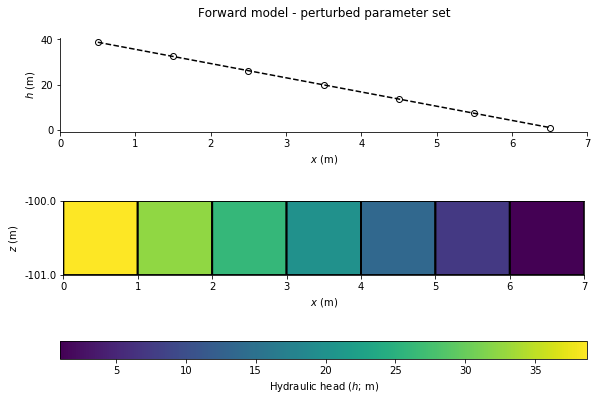

In [8]:
f,s = plt.subplots(2, 1, figsize=[24.00/2.54, 17.00/2.54])
s[0].set_aspect(0.03)
s[0].set_title('Forward model - perturbed parameter set\n')
s[0].plot(0.5+np.arange(ncol), hds_pert.flatten(), 'ko--', mfc='none')
s[0].set_xlabel('$x$ (m)')
s[0].set_ylabel('$h$ (m)')
s[0].spines['top'].set_visible(False)            
s[0].spines['right'].set_visible(False)            
s[1].set_aspect('equal')
p = s[1].pcolor(hds_pert, edgecolors='k', linewidths=2, cmap='viridis')
s[1].set_xlabel('$x$ (m)')
s[1].set_ylabel('$z$ (m)')
s[1].set_yticks([0., 1.])
s[1].set_yticklabels([-101., -100.])
l = f.colorbar(p, orientation='horizontal', pad=0.4, aspect=30, label='Hydraulic head ($h$; m)')
d = s[0].set_xlim(s[1].get_xlim())

Third, the perturbation-based sensitivity is calculated.

In [9]:
dh_dBC3h_pert = (hob_pert-hob_base)/(BC3h*dpar)

### 3. Sensitivity calculation using adjoint state-based approach

First, the adjoint state model is defined. This is mostly identical to the forward model, except for three conditions: 
1. The value specified on the Dirichlet boundary condition is set to zero.
2. The Robin boundary condition is omitted. 
3. The source of adjoint state is specified at the location of the hydraulic head observation of interest using a  source term with flux magnitude equal to unity.

In [10]:
md = 'adjoint'
ml = model(md, nrow, ncol, delr, K, BC1h, BC3h, BC3c)    

ml.remove_package('bas6')
ibound = np.ones([nrow, ncol], dtype=int)
ibound[:, ncol-1] = -1
strt = np.zeros([nrow, ncol])
flopy.modflow.ModflowBas(ml, ibound=ibound, strt=strt)

ml.remove_package('ghb')
flopy.modflow.ModflowGhb(ml, stress_period_data={0: [0, 0, 0, 0., BC3c]}, ipakcb=53)

flopy.modflow.ModflowWel(ml, stress_period_data={0: [0, 0, ocol, 1.]}, ipakcb=53)

ml.write_input()
success, buff = ml.run_model(silent=True)

adj = np.reshape(np.loadtxt(md+'/'+'HDS.arr'), [1, ncol])

The adjoint state model grid and boundary conditions can be presented visually as follows.

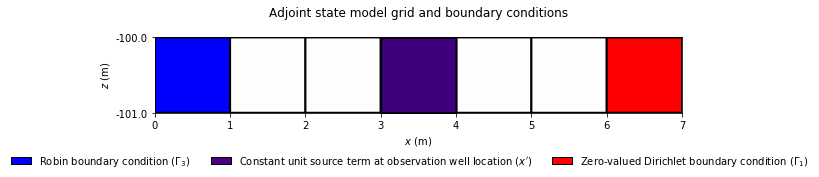

In [11]:
f,s = plt.subplots(1, 1, figsize=[24.00/2.54, 7.00/2.54])
s.set_aspect('equal')
s.set_title('Adjoint state model grid and boundary conditions\n')
grid = np.hstack([np.zeros([1,1]), 0.5*np.ones([1, ncol-2]), np.ones([1,1])])
s.pcolor(grid, edgecolors='k', linewidths=2, cmap='bwr', vmin=0.0, vmax=1.0)
grid[0, ocol] = 2.
s.pcolor(np.ma.masked_not_equal(grid, 2.), edgecolors='k', linewidths=2, cmap='Purples', vmin=0.0, vmax=2.0)
s.set_xlabel('$x$ (m)')
s.set_ylabel('$z$ (m)')
s.set_yticks([0., 1.])
s.set_yticklabels([-101., -100.])
l = f.legend(handles=[Patch(facecolor='b', edgecolor='k', label='Robin boundary condition ($\Gamma_3$)'),
                      Patch(facecolor='indigo', edgecolor='k', 
                            label="Constant unit source term at observation well location ($x'$)"),
                      Patch(facecolor='r', edgecolor='k', 
                            label='Zero-valued Dirichlet boundary condition ($\Gamma_1$)')], 
             fancybox=False, frameon=False, loc=8, ncol=3)

The spatial distribution of the adjoint state variable calculated by the adjoint model can be presented visually as follows. Note that the value of the adjoint state variable is zero at the right-most cell; this is because the Dirichlet boundary condition is zero-valued in the adjoint state model.

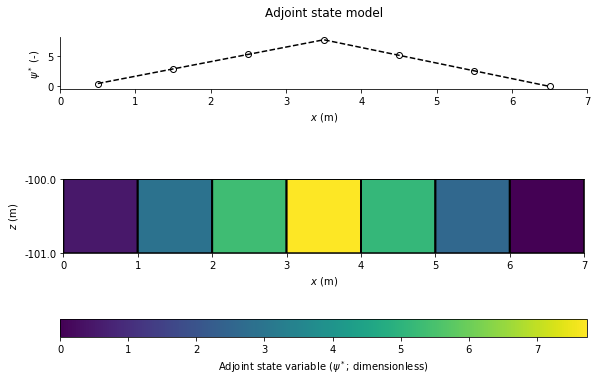

In [12]:
f,s = plt.subplots(2, 1, figsize=[24.00/2.54, 17.00/2.54])
s[0].set_aspect(0.08)
s[0].set_title('Adjoint state model\n')
s[0].plot(0.5+np.arange(ncol), adj.flatten(), 'ko--', mfc='none')
s[0].set_xlabel('$x$ (m)')
s[0].set_ylabel('$\psi^*$ (-)')
s[0].spines['top'].set_visible(False)            
s[0].spines['right'].set_visible(False)            
s[1].set_aspect('equal')
p = s[1].pcolor(adj, edgecolors='k', linewidths=2, cmap='viridis')
s[1].set_xlabel('$x$ (m)')
s[1].set_ylabel('$z$ (m)')
s[1].set_yticks([0., 1.])
s[1].set_yticklabels([-101., -100.])
l = f.colorbar(p, orientation='horizontal', pad=0.4, aspect=30, label='Adjoint state variable ($\psi^*$; dimensionless)')
d = s[0].set_xlim(s[1].get_xlim())

Second, the adjoint state sensitivity is calculated. For this example [i.e. for the sensitivity $\partial h(x')/\partial h_{\Gamma_3}$], this is calculated using adjoint model outputs only, as described by the equation presented above.

In [13]:
dh_dBC3h_adj = np.dot(np.dot(adj, dA_dBC3h), hds_base.T)

### 4. Comparison of calculated sensitivities

In [14]:
print 'Perturbation-based sensitivity  = '+str('%14.6f'%  dh_dBC3h_pert)
print 'Adjoint state-based sensitivity = '+str('%14.6f'%  dh_dBC3h_adj)
print
print 'Ratio                           = '+str('%14.6e'% (dh_dBC3h_pert/dh_dBC3h_adj))
print 'Difference (absolute)           = '+str('%14.6e'% (dh_dBC3h_adj-dh_dBC3h_pert))
print 'Difference (percent)            = '+str('%14.6e'%  abs((dh_dBC3h_adj-dh_dBC3h_pert)/dh_dBC3h_pert))

Perturbation-based sensitivity  =       0.475000
Adjoint state-based sensitivity =      18.746082

Ratio                           =   2.533863e-02
Difference (absolute)           =   1.827108e+01
Difference (percent)            =   3.846544e+01
